# Kaggle Project - 12: Feedback Prize English Language Learning

## Dwaipayan Mukherjee (2211569, AIA - AIML)

# Necessary Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Understanding the data

In [3]:
train = pd.read_csv('train.csv')
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [4]:
ATTRS = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
MAX_PTS = 5

## Histogram
First, I want to observe the distribution of each class

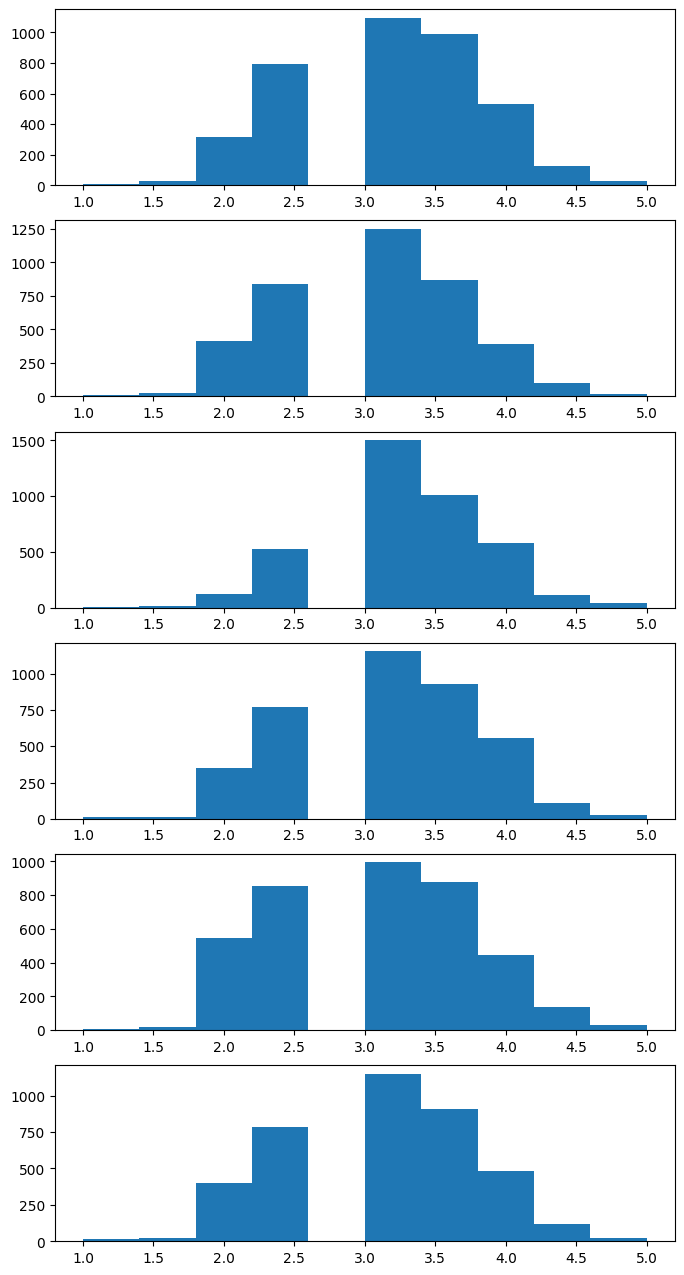

In [5]:
n = len(ATTRS)
plt.figure(figsize=(8, 16))
for i, attr in enumerate(ATTRS):
    plt.subplot(n, 1, i+1)
    plt.hist(train[attr])

## Boxplots
Take a closer look at the classes's median, std, and outliers

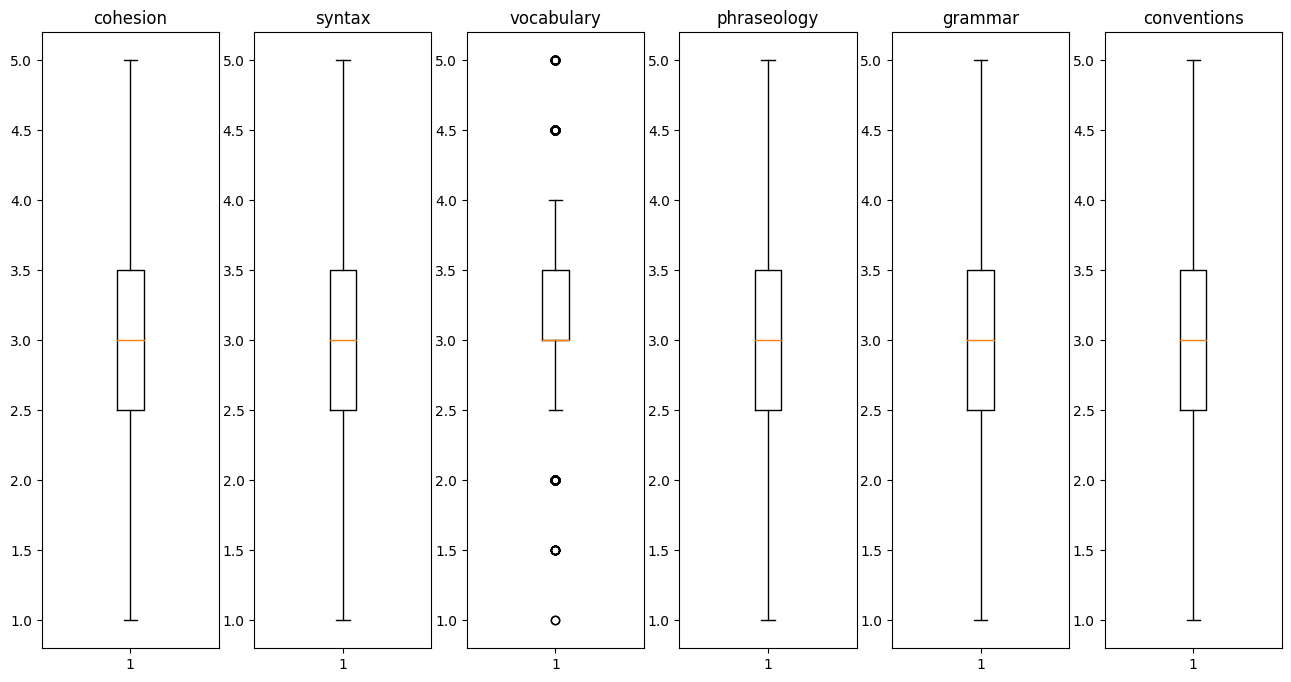

In [6]:
plt.figure(figsize=(16, 8))
for i, attr in enumerate(ATTRS):
    plt.subplot(1, n, i+1)
    plt.boxplot(train[attr])
    plt.title(attr)

## Heatmap
Bringing real-world knowledge into this problem, I want to observe how the length of the text or the number of stop words can possibly impact the scores

In [7]:
import nltk
nltk.download('punkt')
#Download of stopwords
nltk.download('stopwords')
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')
print(len(eng_stop_words))
eng_stop_words[:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


179


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [8]:
train['tokens'] = train.full_text.apply(lambda x: nltk.word_tokenize(x.lower()))
train['text_len'] = train.tokens.apply(lambda x: len(x))
train['stop_words_len'] = train.tokens.apply(lambda x: len([w for w in x if w in eng_stop_words]))
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,tokens,text_len,stop_words_len
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,"[i, think, that, students, would, benefit, fro...",283,133
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,"[when, a, problem, is, a, change, you, have, t...",554,318
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,"[dear, ,, principal, if, u, change, the, schoo...",356,187
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,"[the, best, time, in, life, is, when, you, bec...",836,446
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,"[small, act, of, kindness, can, impact, in, ot...",237,122


<Axes: >

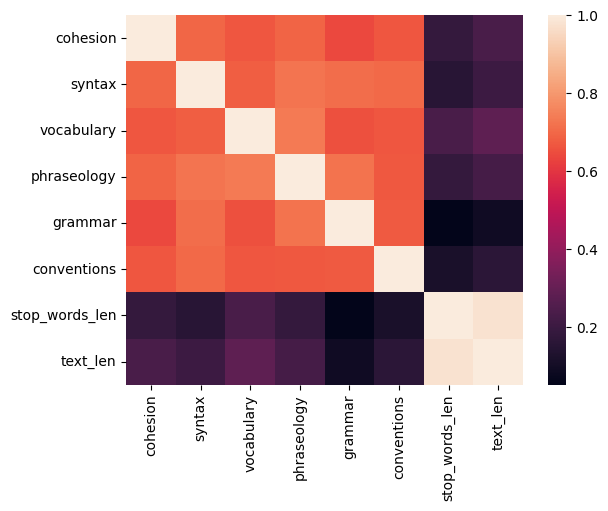

In [9]:
# calculate the correlation matrix
corr = train[ATTRS + ['stop_words_len', 'text_len']].corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

# Modelling
Let's start simple with TD-IDF for feature extraction and Decision Tree for modelling

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn import tree

In [11]:
X = train['full_text'].values
y = train[ATTRS].values

In [12]:
X.shape

(3911,)

In [13]:
y.shape

(3911, 6)

Since we are evaluating the essays, I think it could be reasonable to introduce `ngram_range` to `TfidfVectorizer`. After visualizing the decision tree from the previous versions, I realize that the decision tree mostly split on stop words. However, it's not reasonable to remove stop words because we are evaluating essays.

To resolve this, I would use 2 feature extractors:
1. TD-IDF extractor with ngrame_range=(3,6), which can be helpful for grammar or cohesion classes
2. TD-IDF extractor with stop words extraction, which helps introduce more information in the decision tree

In [14]:
vectorizer_ngram = TfidfVectorizer(ngram_range=(3, 6), max_features=1000)
vectorizer_stop_words = TfidfVectorizer(stop_words=eng_stop_words, max_df=0.7, max_features=500)

feature_extractor = FeatureUnion([
    ('tfidf_ngram', vectorizer_ngram),
    ('tfidf_stop_words', vectorizer_stop_words),
])

X = feature_extractor.fit_transform(X)

print(X.shape)

(3911, 1500)


In [15]:
from sklearn import tree
reg = tree.DecisionTreeRegressor()
reg = reg.fit(X, y)

In [16]:
r = tree.export_text(reg, feature_names=feature_extractor.get_feature_names_out().tolist())
print(r)

|--- tfidf_stop_words__would <= 0.01
|   |--- tfidf_stop_words__could <= 0.02
|   |   |--- tfidf_stop_words__instead <= 0.02
|   |   |   |--- tfidf_stop_words__might <= 0.02
|   |   |   |   |--- tfidf_stop_words__also <= 0.01
|   |   |   |   |   |--- tfidf_stop_words__even <= 0.00
|   |   |   |   |   |   |--- tfidf_stop_words__conclusion <= 0.02
|   |   |   |   |   |   |   |--- tfidf_stop_words__comes <= 0.04
|   |   |   |   |   |   |   |   |--- tfidf_stop_words__makes <= 0.04
|   |   |   |   |   |   |   |   |   |--- tfidf_stop_words__order <= 0.01
|   |   |   |   |   |   |   |   |   |   |--- tfidf_stop_words__reasons <= 0.15
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 42
|   |   |   |   |   |   |   |   |   |   |--- tfidf_stop_words__reasons >  0.15
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |--- tfidf_stop_words__order >  0.01
|   |   |   |   |   |   |   |   |   |   |--- tfidf_stop_wor

In [17]:
test = pd.read_csv('test.csv')
test.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [18]:
X_test = test['full_text'].values

In [19]:
X_test = feature_extractor.transform(X_test)

print(X_test.shape)

(3, 1500)


In [20]:
y_test = reg.predict(X_test)
print(y_test.shape)

(3, 6)


In [21]:
test[ATTRS] = y_test
test.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,2.5,3.0,3.0,2.0,2.5,2.5
1,000BAD50D026,Do you think students would benefit from being...,3.5,3.5,3.0,3.5,3.5,3.5
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",3.0,3.5,3.5,3.5,3.0,3.0


In [22]:
test[['text_id'] + ATTRS]

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,2.5,3.0,3.0,2.0,2.5,2.5
1,000BAD50D026,3.5,3.5,3.0,3.5,3.5,3.5
2,00367BB2546B,3.0,3.5,3.5,3.5,3.0,3.0


In [23]:
test[['text_id'] + ATTRS].to_csv('submission.csv',index=False)